# LIBRARIES

In [1]:
from preprocess import load_data, merge_data, calculate_rewards, preprocess_data
from sar import generate_states, generate_actions, get_reward, calculate_reward, get_subject_line
from qagent import QLearningAgent
from metrics import Metrics
from train import train_agent
from report import save_report
import numpy as np
import datetime
import pickle

# LOAD DATA

In [2]:
# Load data
userbase_file = 'userbase.csv'
sent_file = 'sent_emails.csv'
responded_file = 'responded.csv'

# DATA

In [3]:
# Setup dataframes
userbase, sent, responded = load_data(userbase_file, sent_file, responded_file)

## Merge

In [4]:
# Merge data
important_features = ['Gender', 'Type', 'Age', 'Tenure']
merged_data = merge_data(sent, userbase, responded, important_features)

In [5]:
merged_data.head(5)

,Sent_Date,Customer_ID,SubjectLine_ID_x,Gender,Type,Age,Tenure,Responded_Date,SubjectLine_ID_y
0,2016-01-28,1413,2,M,B,44,12,2016-01-31,2.0
1,2016-03-02,83889,2,M,C,29,23,2016-02-20,3.0
2,2016-03-09,457832,3,M,C,26,14,NaN,NaN
3,2016-01-20,127772,1,M,C,26,15,NaN,NaN
4,2016-02-03,192123,3,M,C,33,9,2016-02-04,3.0


## Rewards

In [6]:
# Calculate rewards
merged_data = calculate_rewards(merged_data)

In [7]:
merged_data.head(5)

,Sent_Date,Customer_ID,SubLine_Sent,Gender,Type,Age,Tenure,Responded_Date,SubLine_Responded,Reward
0,2016-01-28,1413,2,M,B,44,12,2016-01-31,2.0,0
1,2016-03-02,83889,2,M,C,29,23,2016-02-20,3.0,0
2,2016-03-09,457832,3,M,C,26,14,1900-01-01 00:00:00,-1.0,0
3,2016-01-20,127772,1,M,C,26,15,1900-01-01 00:00:00,-1.0,0
4,2016-02-03,192123,3,M,C,33,9,2016-02-04,3.0,0


## States

In [8]:
# STATES
states = generate_states(merged_data)

In [9]:
print(states[:5])

[('M', 'B', 44, 12), ('M', 'B', 44, 23), ('M', 'B', 44, 14), ('M', 'B', 44, 15), ('M', 'B', 44, 9)]


In [10]:
# Initialize a dictionary to store rewards for each state
state_rewards = {state: get_reward(state, merged_data, states) for state in states}

In [11]:
for key in list(state_rewards.keys())[:5]:
    print(key, state_rewards[key])

('M', 'B', 44, 12) 0
('M', 'B', 44, 23) 0
('M', 'B', 44, 14) 0
('M', 'B', 44, 15) 0
('M', 'B', 44, 9) 0


## Actions

In [12]:
# Initialize a dictionary to store actions for each state
state_actions = {state: get_subject_line(state, merged_data, states) for state in states}

In [13]:
for key in list(state_actions.keys())[:5]:
    print(key, state_actions[key])

('M', 'B', 44, 12) 2
('M', 'B', 44, 23) 1
('M', 'B', 44, 14) 3
('M', 'B', 44, 15) 1
('M', 'B', 44, 9) 1


In [14]:
# ACTIONS
actions = generate_actions(merged_data)

In [15]:
print(actions)

[2 3 1]


In [16]:
# Parameters
state_size = len(states)
action_size = len(actions)

In [17]:
print("State Size:", state_size)
print("Action Size:", action_size)

State Size: 6992
Action Size: 3


# AGENT

## Initialize


In [18]:
# Initialize the Q-learning agent
agent = QLearningAgent(state_size, action_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1)

## Train

In [19]:
# Training
training_rewards, episodes_to_convergence = train_agent(agent, states, merged_data)

Convergence reached. Stopping training.


In [20]:
# Calculate discounted rewards
discounted_rewards = [reward * (0.9 ** i) for i, reward in enumerate(training_rewards)]

## Metrics

In [21]:
metrics = Metrics(training_rewards, discount_factor=0.9)

## Save

In [22]:
Q_table = agent.get_q_table()
with open('q_table.pkl', 'wb') as f:
    pickle.dump(Q_table, f)

In [23]:
# print the Q table
print(Q_table)

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.66475788 0.         0.        ]
 ...
 [0.8010504  0.         0.        ]
 [0.57856124 0.         0.        ]
 [0.         0.         0.        ]]


## RESULTS

In [24]:
# Print and plot the metrics
print("Cumulative Rewards:", metrics.cumulative_rewards[-1])
print("Average Reward:", metrics.average_reward)
print("Discounted Reward:", metrics.discounted_rewards[0])

Cumulative Rewards: 148750
Average Reward: 595.0
Discounted Reward: 5949.999999978369


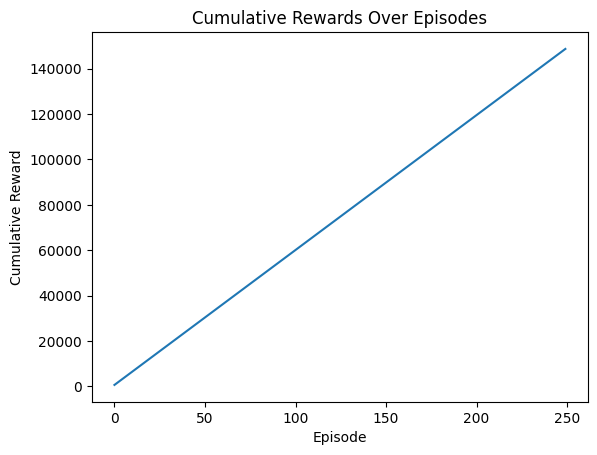

In [25]:
metrics.plot_cumulative_rewards()

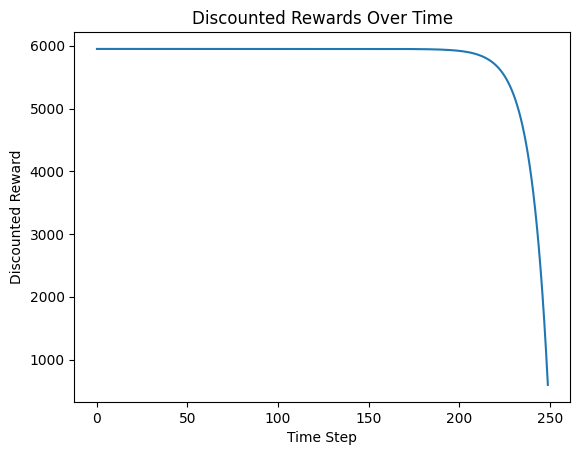

In [26]:
metrics.plot_discounted_rewards()


In [28]:
if episodes_to_convergence is not None:
    print("Episodes to Convergence:", episodes_to_convergence)
else:
    print("Convergence not reached within the maximum number of episodes.")

Episodes to Convergence: 241


# Model Inference

In [29]:
# printing old subject line and new subject line given by the model
print(f"{'Old Subject Line':20} | {'New Subject Line':20}")
print("-" * 41)
for state in states:
    action = agent.get_action(state)
    old_subject_line = state_actions[state]  # Get the old subject line based on the state
    new_subject_line = actions[action]  # Get the new subject line based on the action
    print(f"{old_subject_line: 20} | {new_subject_line: 1}")




Old Subject Line     | New Subject Line    
-----------------------------------------
                   2 |  1
                   1 |  3
                   3 |  2
                   1 |  3
                   1 |  3
                   3 |  2
                   2 |  1
                   2 |  1
                   1 |  3
                   1 |  3
                   2 |  1
                   2 |  1
                   3 |  2
                   3 |  2
                   2 |  1
                   3 |  2
                   1 |  3
                   3 |  2
                   1 |  3
                   2 |  1
                   2 |  1
                   1 |  3
                   3 |  2
                   1 |  3
                   2 |  1
                   3 |  2
                   1 |  3
                   3 |  2
                   2 |  1
                   1 |  3
                   3 |  2
                   1 |  3
                   3 |  2
                   3 |  2
                   3 |  2
    